# Policy responses to COVID-19 in an East African Context

## Introduction

The ongoing COVID-19  pandemic presents incredible and unprecedented challenges to governments and policy makers around the world. Crafting policies to ensure the safety of citizens against a backdrop of precarious information surrounding the nature of the coronavirus as well as a global economic downturn constraining budgets has been a herculean task. Government policies within an East-African context have had the unique need of balancing COVID-19  prevention measures with fiscal and healthcare capacity constraints, whilst ensuring that some level of economic activity continues for a population that is largely young and employed in the informal sector (thus largely unable to ‘work from home’) (Alon, Kim, Lagakos, & VanVuren, 2020) (Ogbolosingha & Singh, 2020). This report aims to highlight the various policies adopted by the Rwandan government (a member of the East African Community (EAC) (East African Community, 2020)) in response to the COVID-19  pandemic with the motivating question of, ‘How effective has the policy response of Rwanda, been in reducing the spread of COVID-19 ’?


The focus on East-Africa is made for two reasons, firstly global reporting of COVID-19  shows that the impact of the virus (in terms of the proportion of people infected, recovered/died) varies greatly per country which is leading to a growing body of literature analyzing these differences, focusing on a specific region allows for a more effective comparison (Hale, et al., 2020). The second is that countries in the East African region are similar both socio-economically and demographically and therefore the assertion can be made that different outcomes in terms of COVID-19  infection rates are the product of differing policies by country (East African Community Secretariat, 2019) (Ogbolosingha & Singh, 2020). This analysis is further limited to Rwanda to allow for greater focus in the report. The individual response of the Rwandan government will first be analysed before delving into comparisons to other countries with focus on other EAC members (Uganda, Burundi, Tanzania, Kenya, South Sudan) (East African Community, 2020). 


Using an incomplete-markets macroeconomic model to compare how policies to the COVID-19  pandemic should differ between developing and developed countries Alon et al (2020) predict that blanket lockdowns are less effective in developing countries as compared to developed countries whilst age-specific restrictions such as school closures are more effective in developing countries, this motivates an analysis of the correlations between the imposition of school closures and infection rates. These findings were based on differences in age structures (younger population), fiscal and healthcare capacity, informality, as well as the frequency of contacts (schools tend to be more crowded and there is a greater prevalence of intergenerational cohabitation).


In response to the COVID-19  pandemic Rwanda employed a mix of various policy measures ranging from shutting down international borders to contact tracing to public information campaigns (Dickson, 2020). This report shall focus on the duration and severity of containment and closure measures namely: School closures, workplace closures, cancellation of public events, restrictions on gathering sizes, closure of public transport, stay at home requirements, restrictions on internal movement and restrictions on international travel as recorded within the OXCOVID-19 database (Mahdi, et al., 2020).

# Code 

In [3]:
try: 
    import seaborn as sns
    if sns.__version__ == "0.11.0": 
        pass
    else: 
        import sys
        !{sys.executable} -m pip install --upgrade seaborn==0.11.0
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install seaborn==0.11.0
    import seaborn as sns
    
print(sns.__version__ == "0.11.0")

True


In [2]:
import psycopg2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200

import seaborn as sns

import numpy as np
import pandas as pd
import math 
import datetime

from bs4 import BeautifulSoup 


In [4]:
# Create Connection following official github documentation - Download required data and close connection
conn = psycopg2.connect(
    host='covid19db.org',
    port=****,
    dbname='covid19',
    user='covid19',
    password=*******)
cur = conn.cursor()

# Data limited by date here to reduce query load by only requesting necessary data, surplus of columns included to allow for exploratory analysis
sql_command_1 = """SELECT * 
                    FROM GOVERNMENT_RESPONSE 
                    WHERE date<'2020-11-01' """
                    # WHERE (country ='Kenya' OR country ='Uganda' OR country ='Rwanda')
                    # AND date<'2020-11-01' """
df_govResponse = pd.read_sql(sql_command_1, conn)

# Data limited by date here to reduce query load by only requesting necessary data, surplus of columns included to allow for exploratory analysis
sql_command_2 = """SELECT * 
                    FROM epidemiology 
                    WHERE date>'2019-12-31' AND date<'2020-11-01'
                        AND source = 'WRD_WHO' """
                    # WHERE (country ='Kenya' OR country ='Uganda' OR country ='Rwanda')
                    # AND date<'2020-11-01' AND date>'2019-12-31' """
df_epidemiology = pd.read_sql(sql_command_2, conn)

# minimal and only relevant data retrieved here
sql_command_3 = """SELECT country, countrycode, value AS total_population 
                    FROM world_bank 
                    WHERE indicator_name = 'Population, total' AND source = 'World Bank' """
df_country_stats = pd.read_sql(sql_command_3, conn)


conn.close()

In [5]:
# Format date variable, check correct range merge tables 

df_govResponse['date'] = pd.to_datetime(df_govResponse['date'],format='%Y-%m-%d')
assert max(df_govResponse['date'])<pd.to_datetime('2020-11-01'), "Max date filter not correct"
assert min(df_govResponse['date'])>pd.to_datetime('2019-12-31'), "Min date filter not correct"

df_epidemiology['date'] = pd.to_datetime(df_epidemiology['date'],format='%Y-%m-%d')
assert max(df_epidemiology['date'])<pd.to_datetime('2020-11-01'), "Max date filter not correct"
assert min(df_epidemiology['date'])>pd.to_datetime('2019-12-31'), "Min date filter not correct"

df_epidem_GovR_merge = df_epidemiology.merge(df_govResponse, how='inner', on=['date','country'])
assert df_epidem_GovR_merge[df_epidem_GovR_merge['country']=='Rwanda']['government_response_index_for_display'].isna().sum()==0, "Missing Values for Rwanda's Gov response"
assert df_epidem_GovR_merge[df_epidem_GovR_merge['country']=='Rwanda']['confirmed'].isna().sum() ==0, "Missing values for Rwanda's Confirmed cases"

In [6]:
# Function to plot government response and number of confirmed cases for a selected country
def plot_Fig1(df,country):
    plt.style.use('seaborn-whitegrid')
    df_func = df[df['country']==country].copy()
    df_func.sort_values('date',inplace=True)
    
    fig, ax1 = plt.subplots()
    fig.set_dpi(150)
    ax1.plot(df_func['date'], df_func['confirmed'],  linestyle='-', color='darkorange', label='log of confirmed cases') # 'confirmed' 'dead'
    ax1.set_title('Figure 1: Overview of government response \n Country: '+country)
    ax1.set_ylabel("log of confirmed cases", color='darkorange')
    ax1.set_yscale('log')
    
    # set graph on right axis
    ax2 = ax1.twinx()
    ax2.plot(df_func['date'], df_func['government_response_index_for_display'],  linestyle='-', color='royalblue', label='Government response index')
    ax2.set_ylabel("Gov resp index", color='royalblue')
    #ax2.tick_params(axis='y', labelcolor='blue')
    ax2.grid(False)
    
    # Following code works to plot the various closure measures
    closure_list = ['c8_international_travel_controls','c3_cancel_public_events'
                ,'c4_restrictions_on_gatherings','c2_workplace_closing','c1_school_closing'
                ,'c5_close_public_transport','c6_stay_at_home_requirements'
                ,'c7_restrictions_on_internal_movement']
    df_func.sort_values('date',inplace=True)
    for closure in closure_list:
        restriction = "First_"+closure[3:-2]
        first_date = df_func[df_func[closure]>0][['country','date']].groupby('country').min()['date'][0] 
        gov_response_level = float(df_func[df_func['date']==first_date]['government_response_index_for_display'])
        sc_label = closure + " - " + str(first_date)[:10]
        ax2.scatter(first_date,gov_response_level,marker='x',label =sc_label)
    
    # Format x axis of graph 
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    datemin = datetime.date(2020,1,1)
    datemax = datetime.date(2020,10,31) # 11,1)
    ax1.set_xlim(datemin, datemax)
    date_form = DateFormatter("%b")
    ax1.xaxis.set_major_formatter(date_form)
    
    fig.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)

In [7]:
# Set null values to '0' for each closure index value before summation to create new index

# Format individual columns setting null values to '0' in preparation of creating 'closure' index
df_govResponse['c1_school_closing_1'] = df_govResponse['c1_school_closing'].apply(lambda x: 0 if pd.isna(x) else x)
df_govResponse['c2_workplace_closing_1'] = df_govResponse['c2_workplace_closing'].apply(lambda x: 0 if pd.isna(x) else x)
df_govResponse['c3_cancel_public_events_1'] = df_govResponse['c3_cancel_public_events'].apply(lambda x: 0 if pd.isna(x) else x)
df_govResponse['c4_restrictions_on_gatherings_1'] = df_govResponse['c4_restrictions_on_gatherings'].apply(lambda x: 0 if pd.isna(x) else x)
df_govResponse['c5_close_public_transport_1'] = df_govResponse['c5_close_public_transport'].apply(lambda x: 0 if pd.isna(x) else x)
df_govResponse['c6_stay_at_home_requirements_1'] = df_govResponse['c6_stay_at_home_requirements'].apply(lambda x: 0 if pd.isna(x) else x)
df_govResponse['c7_restrictions_on_internal_movement_1'] = df_govResponse['c7_restrictions_on_internal_movement'].apply(lambda x: 0 if pd.isna(x) else x)
df_govResponse['c8_international_travel_controls_1'] = df_govResponse['c8_international_travel_controls'].apply(lambda x: 0 if pd.isna(x) else x)


df_govResponse['index_all_closures']= (df_govResponse['c1_school_closing_1'] + df_govResponse['c2_workplace_closing_1'] \
+ df_govResponse['c3_cancel_public_events_1'] + df_govResponse['c4_restrictions_on_gatherings_1'] \
+ df_govResponse['c5_close_public_transport_1'] + df_govResponse['c6_stay_at_home_requirements_1'] \
+ df_govResponse['c7_restrictions_on_internal_movement_1'] + df_govResponse['c8_international_travel_controls_1'])

assert df_govResponse['index_all_closures'].isna().sum()==0, "Null values present in variable"

# Create Dataframe with countries and the maximum number of confirmed cases per 100,000 (population)
assert df_country_stats.duplicated().sum()==0, "Duplicate rows present"
assert df_country_stats.isna().sum().sum()==0, " 'na's present present"
if 'max_confirmed_cases' not in df_country_stats.columns:
    df_country_stats = df_country_stats.merge(df_epidemiology[['country','confirmed']].groupby(['country']).max(), how='inner',on='country')
    df_country_stats.rename(columns={'confirmed':'max_confirmed_cases'}, inplace=True)

df_country_stats['max_confirmed_per_100000'] = df_country_stats['max_confirmed_cases']/(df_country_stats['total_population']/100000)

In [8]:
# Two separate tables created here: df_country_closures with the countries and the first date for each closure and 
# 'df_country_confirmed' with the first date a covid case was confirmed
# Tables are created then merged
df_country_closures = df_govResponse[df_govResponse['index_all_closures']>0][['country','date']].groupby('country').min('date')
df_country_closures.rename(columns={'date':'date_first_closure'}, inplace=True)

df_country_confirmed = df_epidemiology[df_epidemiology['confirmed']>0][['country','date']].groupby('country').min('date')
df_country_confirmed.rename(columns={'date':'date_first_confirmed'}, inplace=True)

df_closure_confirmed = df_country_closures.merge(df_country_confirmed, how='inner', on='country')
df_closure_confirmed.reset_index(inplace=True)

# Calculating time in days between first closure and first confirmed covid case
df_closure_confirmed['timeD_conf_closure']=df_closure_confirmed['date_first_closure']-df_closure_confirmed['date_first_confirmed']
df_closure_confirmed['days_between_conf_closure'] = df_closure_confirmed['timeD_conf_closure'].map(lambda x: x.days)

# Tables are now merged with table containing the maximum number of confirmed cases for each country per 100,000 people
df_closure_confirmed= df_closure_confirmed.merge(df_country_stats[['country','max_confirmed_per_100000']], how='inner',on='country')

In [9]:
def plot_PolicyR_Confirmed_scatter(df,country,comparison_countries):
    plt.style.use('seaborn-whitegrid')
    
    fig, ax1 = plt.subplots()
    fig.set_dpi(150)
    x= df['days_between_conf_closure'].drop([174,143],inplace=False)
    y= df['max_confirmed_per_100000'].drop([174,143],inplace=False)
    ax1.scatter(x, y, color='royalblue', s=100, alpha=0.5)
    
    df_outliers = df[df['days_between_conf_closure']>150].copy()
    df_outliers = df_outliers.append(df[df['days_between_conf_closure']<-150])
    x_o = df_outliers['days_between_conf_closure']
    y_o = df_outliers['max_confirmed_per_100000']
    ax1.scatter(x_o, y_o, color='royalblue', s=100, alpha=0.5)
    
    focus_countries = [country] + comparison_countries
    cols = {0:'orange',1:'violet',2:'olive',3:'limegreen',4:'deeppink'}
    count = 0
    for cntry in focus_countries:
        x_country = df[df['country']==cntry]['days_between_conf_closure']
        y_country = df[df['country']==cntry]['max_confirmed_per_100000']
        if cntry==country:
            ax1.scatter(x_country, y_country, marker='v', color = 'red', s=130, label=cntry)
        else:
            ax1.scatter(x_country, y_country, marker='o', s=120,color = cols[count], label=cntry)
            count +=1
    
    #plot log linear best fit line
    m,c = np.polyfit(x, np.log(y), 1)
    lin = np.exp(x*m +c)
    ax1.plot(x,lin,color='black')
    
    ax1.set_yscale('log')
    ax1.set_xlim(-250, 200)
    ax1.set_title('Figure 2: Days between first govenment containment/closure measure \n and highest number of COVID-19 confirmed cases \n Timeframe: Jan-01 - Oct-31')
    ax1.set_ylabel("log of confirmed cases")
    ax1.set_xlabel("Number of days between first confirmed COVID-19 case \n and first closure / containment policy")
    fig.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
EAC_countries = ['Uganda','Burundi','Tanzania','Kenya','South Sudan']
Focus_Country = 'Rwanda'

In [10]:
df_govResponse_SchoolC = df_govResponse[df_govResponse["c1_school_closing"]>1][["c1_school_closing","country","date"]].groupby(["country"]).agg({"date": pd.Series.nunique})
df_govResponse_SchoolC.rename(columns={'date':'days_school_closed'}, inplace=True)
df_govResponse_SchoolC= df_govResponse_SchoolC.merge(df_country_stats[['country','max_confirmed_per_100000']], how='inner',on='country')

In [11]:
def plot_SchoolC_Confirmed_scatter(df,country,comparison_countries):
    plt.style.use('seaborn-whitegrid')
    
    fig, ax1 = plt.subplots()
    fig.set_dpi(150)
    x= df['days_school_closed']
    y= df['max_confirmed_per_100000']
    ax1.scatter(x, y, color='royalblue', s=100, alpha=0.5)
    
    focus_countries = [country] + comparison_countries
    cols = {0:'orange',1:'violet',2:'olive',3:'limegreen',4:'deeppink'}
    count = 0
    for cntry in focus_countries:
        x_country = df[df['country']==cntry]['days_school_closed']
        y_country = df[df['country']==cntry]['max_confirmed_per_100000']
        if cntry==country:
            ax1.scatter(x_country, y_country, marker='v', color = 'red', s=130, label=cntry)
        elif len(x_country)>0 and len(y_country)>0:
            ax1.scatter(x_country, y_country, marker='o', s=120,color = cols[count], label=cntry)
            count +=1
    
    #plot log linear best fit line
    # Exclude Vanuatu from calculation as school closed=53 but confirmed cases=0 leading to division by 0
    m,c = np.polyfit(x.drop(170), np.log(y.drop(170)), 1)
    lin = np.exp(x*m +c)
    ax1.plot(x,lin,color='black')
    
    ax1.set_yscale('log')
    #ax1.set_xlim(0, 175)
    ax1.set_title('Figure 3: Number of days schools closed \n and log of highest number of COVID-19 confirmed cases \n Timeframe: Jan-01 - Oct-31')
    ax1.set_ylabel("log of confirmed cases")
    ax1.set_xlabel("Number of days schools were closed for")
    fig.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)

# Discussion 

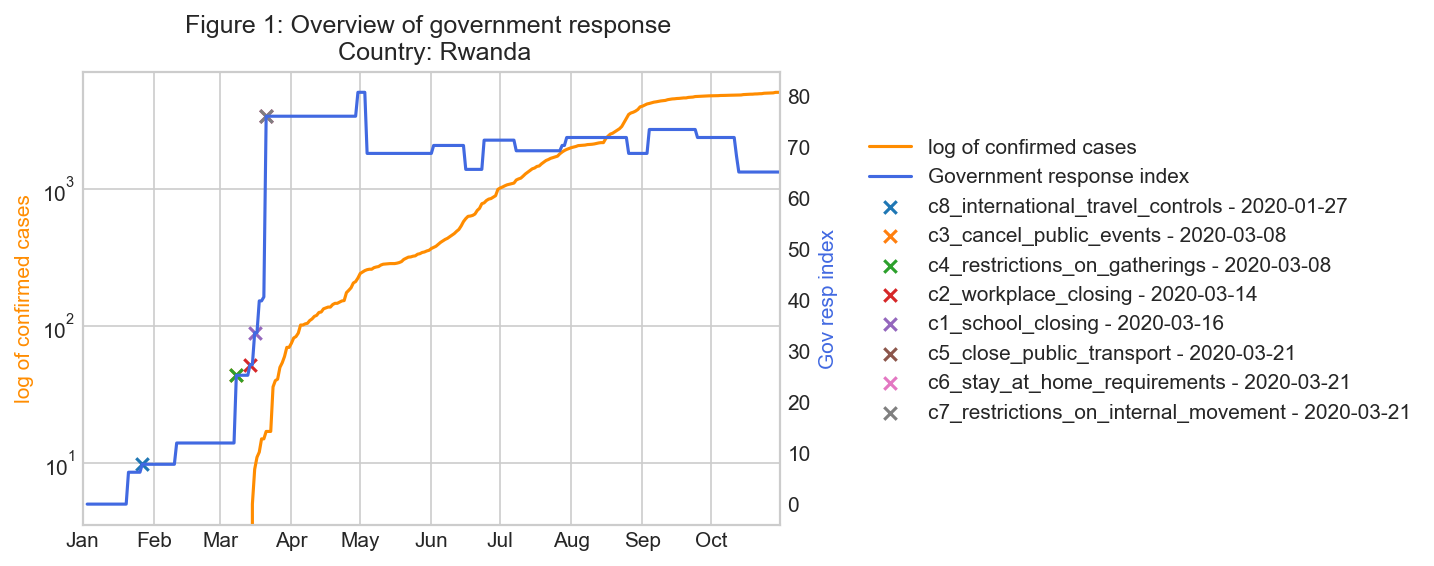

In [12]:
plot_Fig1(df_epidem_GovR_merge,'Rwanda')

An overview of Rwanda’s government response in relation to the number of confirmed COVID-19  cases is given by Figure 1.The purpose of this is to give context on the rate of growth of infections as well as the overall government response towards the pandemic before comparing this response to other countries.

The ‘overall government response index’ used here is taken from the ‘Oxford COVID-19  Government Response Tracker’ (Hale, Webster, Petherick, Phillips, & Kira, 2020) and is a composite of various government response policies, namely: closure and containment measures, health measures as well as economic support policies, measured ordinally and standardized to a scale between 0 – 100 for display purposes, it can therefore give an overview of the severity of policies employed by the government. A logarithmic scale is used for the number of confirmed COVID-19  cases as the rate of COVID-19  infections rises exponentially. ‘Confirmed’ cases is chosen as opposed to the number of people who have died from COVID-19 as this would bear more influence on the initial containment and closure policies.

From the figure one an see that Rwanda implemented its first policy, limiting international travel, over a month before the first confirmed COVID-19 case indicating a highly proactive approach to the then emerging crisis. Policies restricting public events and gatherings were also implemented just before the first confirmed case. Within two weeks of the first confirmed case government containment policies were at the highest severity level, fluctuating only marginally. Correspondingly, the rate of increase in COVID-19 infections was very high in the first two weeks but reduced after that, maintaining a relatively constant rate of increase for five months before reducing this rate of increase in new cases. The severity of containment and closure policies reduced after just over a month after the rate of increase in new COVID-19  infections saw its first reduction indicating a cautious approach to relaxing COVID-19  restrictions.

Overall, the proactive and cautious approach taken by the Rwandan government in response to COVID-19  appears to have had the desired result of slowing down the rate of increase in COVID-19  infections. 
The following graph contextualises this approach, comparing it in terms of the days between the first COVID-19  infection and the first containment/closure policy to other countries.


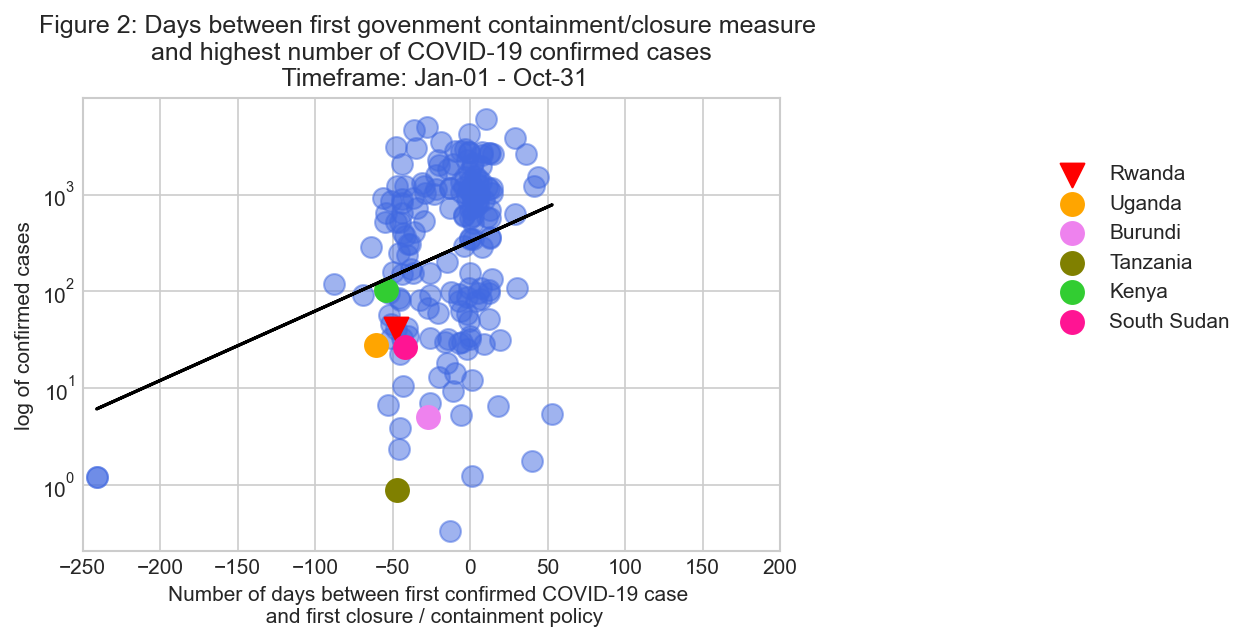

In [13]:
plot_PolicyR_Confirmed_scatter(df_closure_confirmed,Focus_Country,EAC_countries)

Figure two compares the number of days between a countries first lockdown policy concerning closure, namely one or more of: School closures, workplace closures, cancellation of public events, restrictions on gathering sizes, closure of public transport, stay at home requirements, restrictions on internal movement and restrictions on international travel and the maximum number of COVID-19 cases experienced.

From figure two, the response by Rwanda as shown by its point on the graph indicates that it was amongst the earliest to respond to the COVID-19 crisis in comparison to other countries. Majority of countries, as well as majority of the countries with the highest number of COVID-19 confirmed cases, imposed their first 'closure' policy either a few days before or after confirming their first COVID-19 case. Rwanda however imposed their first closure policy close to 50 days before their first confirmed COVID-19 case indicating a highly pre-emptive approach.

The slope of the line of best fit (note: this excludes outlier points) indicates that there is a positive relationship between the number of days between the first confirmed case and the maximum number of confirmed cases recorded, i.e. countries which imposed lockdown measures before their first confirmed case tended to have a lower maximum number of confirmed cases. Considering the logarithmic scale this line is quite steep indicating that the speed at which countries implemented lockdown policies heavily influenced the total number of covid-19 cases the country confirmed.  

In comparison to other countries in the EAC Rwanda’s policy response was amongst the fastest however their maximum number of confirmed cases was amongst the highest as well. Two factors that may explain this discrepancy are that the difference in the number of days between the first confirmed case and the first closure policy were not very large for most countries within the EAC however the testing strategies between the countries may differ quite considerably.

The final area of analysis focuses on the singular policy of school closures. As earlier explained, school closures were identified as a key closure policy that would have a significant and impact in reducing the spread of COVID-19  for countries such as Rwanda.


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


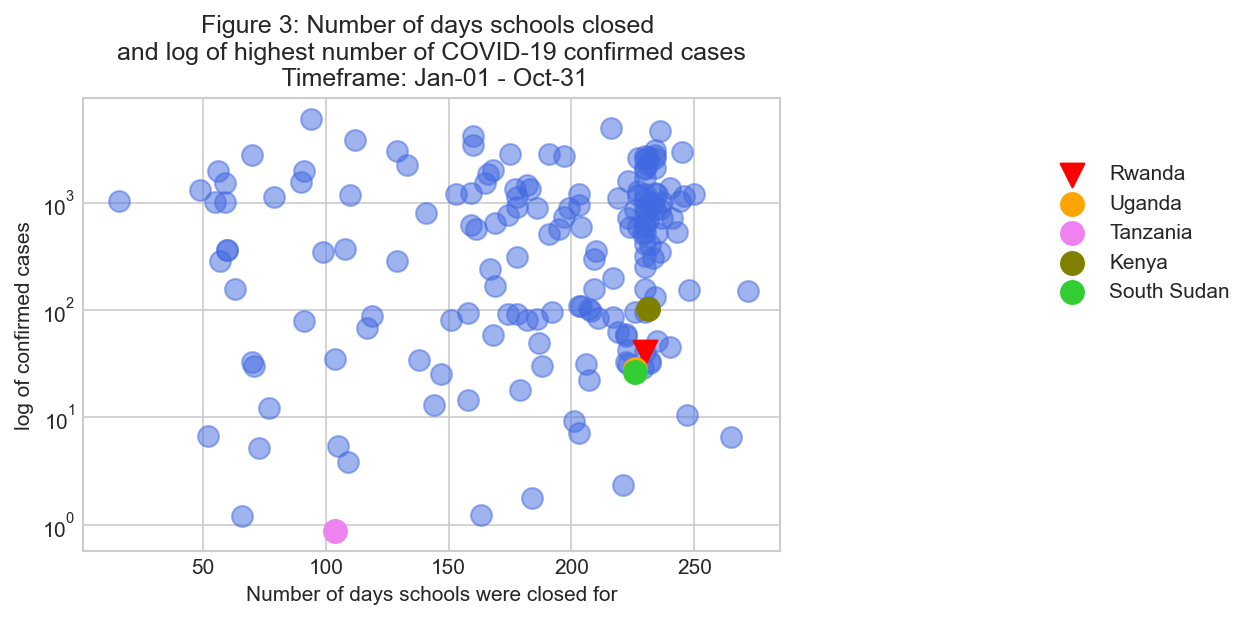

In [14]:
# Note error 'LinAlgError: SVD did not converge in Linear Least Squares' comes up the first time this cell is run but dissappears upon running the cell a second time
plot_SchoolC_Confirmed_scatter(df_govResponse_SchoolC,Focus_Country,EAC_countries)

Figure three compares the number of days schools were closed for (including days when schools were only partially closed across countries) and the maximum number of COVID-19  cases recorded between 1st January and 31 October. As shown by the line of best fit there is a positive relationship between the number of days schools were closed for and the maximum number of confirmed cases. This observation is expected as countries with a higher number of confirmed cases would be less likely to allow schools to freely open.
 
As expected from the literature review, Rwanda is among the countries which closed schools for the longest time period, with schools closed for over 225 days. As compared to other EAC countries Uganda and Kenya maintained closed schools for a similar amount of time whereas Tanzania closed schools for only half the time of the others and recorded much fewer confirmed COVID-19  cases, no data was available for Burundi. The discrepancy with Tanzania can however be explained by limited testing being carried out in Tanzania (BBC, 2020).

Overall The response of the Rwandan government to COVID-19  can be described as cautious and swift, implementing closure policies before the first confirmed case and being amongst the earliest countries to implement closure policies (in reference to the date of the first confirmed COVID-19  case); and effectively stringent, literature indicated that countries with a large young population such as Rwanda would benefit from school closure policies, the duration the Rwandan government closed schools was amongst the longest globally.